In [1]:
import numpy as np
import pandas as pd
import os, re, math, platform
from pathlib import Path
import matplotlib.pyplot as plt
import json
import joblib
from scipy.stats import randint as sp_randint
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from sklearn.metrics import precision_recall_curve, roc_curve, auc, fbeta_score
from imblearn.metrics import geometric_mean_score
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier 
from xgboost import plot_importance
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis as PA
from modlamp.descriptors import PeptideDescriptor, GlobalDescriptor
from matplotlib import pyplot
from sklearn.metrics import matthews_corrcoef, confusion_matrix,precision_recall_curve, roc_curve, auc, fbeta_score,roc_auc_score
from fea_extract import read_fasta,insert_AAC,insert_DPC,insert_CKSAAGP,insert_CTD,insert_PAAC,insert_AAI,insert_GTPC,insert_QSO,insert_AAE,insert_PSAAC,insert_word2int,insert_ASDC
import warnings 
from collections import Counter
from tools import cv,evaluate
import matplotlib.pyplot as plt
import seaborn as sns
Path('./results/balance_eval_AUC/').mkdir(exist_ok=True,parents=True)
warnings.filterwarnings('ignore')
seed=10

In [10]:
def pro_data(seq):
    df_n = insert_PAAC(seq)
    df_n = insert_AAC(df_n)
    df_n = insert_CKSAAGP(df_n)
    df_n = insert_CTD(df_n)
    df_n = insert_DPC(df_n)
    df_n = insert_GTPC(df_n)
    df_n = insert_QSO(df_n)
    df_n = insert_AAE(df_n)
    df_n = insert_ASDC(df_n)
    return df_n

In [3]:
seq_X_train = pd.read_csv('data/train/X_train.csv')
seq_X_test = pd.read_csv('data/test/X_test.csv')
seq_y_train = pd.read_csv('data/train/y_train.csv')
seq_y_test = pd.read_csv('data/test/y_test.csv')

In [4]:
Seq_X_train = pro_data(seq_X_train)
Seq_X_test = pro_data(seq_X_test)

In [41]:
Seq_X_train.to_csv('data/train/Seq_X_train_all.csv',index=False)
Seq_X_test.to_csv('data/test/Seq_X_test_all.csv',index=False)

In [5]:
ml = ["XGBoost","RF","ET","GBDT"]
GBDT = GradientBoostingClassifier(random_state=seed)
ET = ExtraTreesClassifier(random_state=seed)
SVM = SVC(random_state=seed,probability=True)
MLP = MLPClassifier(hidden_layer_sizes=32,learning_rate="adaptive",random_state=seed)
RF = RandomForestClassifier(random_state=seed)
XGBoost = XGBClassifier(random_state=seed)
LR  = LogisticRegression(random_state=seed)
AB = AdaBoostClassifier(random_state=seed)

In [5]:
fea = Seq_X_train.columns[2:]
X_train = Seq_X_train[fea].to_numpy()
X_test = Seq_X_test[fea].to_numpy()
y_train = seq_y_train.to_numpy()
y_test = seq_y_test.to_numpy()

In [14]:
index = []
ALL_eval=pd.DataFrame()
for i in ml:
    print('process_{}'.format(i))
    model = eval(i)
    Evals = cv(model,X_train,y_train)
    ALL_eval = pd.concat([ALL_eval,Evals],axis=1)
    index.append("{}".format(i))
ALL_eval.columns = index

process_XGBoost
process_RF
process_ET
process_SVM
process_MLP
process_GBDT
process_AB


In [10]:
index = []
ALL_eval_test=pd.DataFrame()
for i in ml:
    eval_dict = []
    print('process_{}'.format(i))
    model = eval(i)
    model.fit(X_train,y_train)
    eval_dictionary = evaluate(X_test,y_test,model)
    eval_dict = eval_dict+[eval_dictionary]
    Evals = pd.DataFrame(eval_dict).T
    ALL_eval_test = pd.concat([ALL_eval_test,Evals],axis=1)
    index.append("{}".format(i))
ALL_eval_test.columns = index

process_XGBoost
process_RF
process_ET
process_SVM
process_MLP
process_GBDT
process_AB


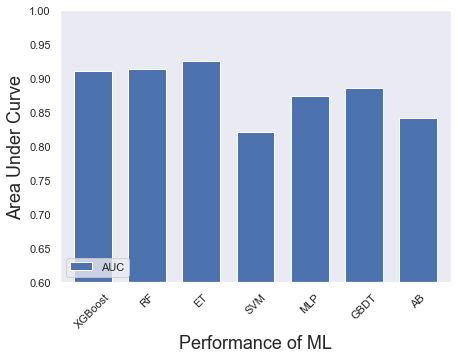

In [8]:
evals = ALL_eval.loc[['AUC'],:]
sns.set()
evals.T.plot.bar(figsize=(7,5),rot=45,width = 0.7,grid = False)
plt.ylim(0.6,1.0)
plt.ylabel('Area Under Curve',fontsize=18)
plt.xlabel('Performance of ML',fontsize=18)
plt.legend(loc =  'lower left' )

In [13]:
ALL_eval_test

,XGBoost,RF,ET,SVM,MLP,GBDT,AB
ACC,0.958042,0.953380,0.960373,0.925408,0.955711,0.946387,0.948718
F1,0.653846,0.583333,0.666667,0.000000,0.677966,0.530612,0.633333
F2,0.574324,0.486111,0.578231,0.000000,0.645161,0.448276,0.608974
GMean,0.726110,0.659770,0.727031,0.000000,0.783569,0.634158,0.761767
SEN,0.531250,0.437500,0.531250,0.000000,0.625000,0.406250,0.593750
PREC,0.850000,0.875000,0.894737,NaN,0.740741,0.764706,0.678571
SPEC,0.992443,0.994962,0.994962,1.000000,0.982368,0.989924,0.977330
MCC,0.652635,0.599630,0.671989,0.000000,0.657093,0.533560,0.607458
AUC,0.943404,0.947300,0.923961,0.893498,0.917349,0.927582,0.945529


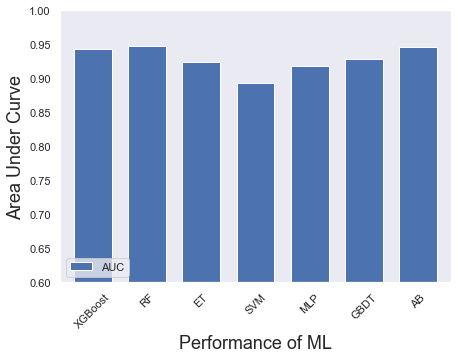

In [12]:
evals = ALL_eval_test.loc[['AUC'],:]
sns.set()
evals.T.plot.bar(figsize=(7,5),rot=45,width = 0.7,grid = False)
plt.ylim(0.6,1.0)
plt.ylabel('Area Under Curve',fontsize=18)
plt.xlabel('Performance of ML',fontsize=18)
plt.legend(loc =  'lower left' )

#### 将数据进行归一化、标准化处理

In [6]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler 

In [39]:
#归一化
nms = MinMaxScaler()
X_train_norm = nms.fit_transform(X_train)
X_test_norm = nms.transform(X_test)
#标准化
stdsc = StandardScaler(with_mean=False)
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

In [42]:
#归一化
X_train_norm1 = pd.DataFrame(X_train_norm)
X_train_norm1.to_csv('data/train/X_train_norm.csv',index=False)
X_test_norm1 = pd.DataFrame(X_test_norm)
X_test_norm1.to_csv('data/test/X_test_norm.csv',index=False)
#标准化
X_train_std1 = pd.DataFrame(X_train_std)
X_train_std1.to_csv('data/train/X_train_std.csv',index=False)
X_test_std1 = pd.DataFrame(X_test_std)
X_test_std1.to_csv('data/test/X_test_std.csv',index=False)

In [24]:
index = []
ALL_eval=pd.DataFrame()
for i in ml:
    print('process_{}'.format(i))
    model = eval(i)
    Evals = cv(model,X_train_std,y_train)
    ALL_eval = pd.concat([ALL_eval,Evals],axis=1)
    index.append("{}".format(i))
ALL_eval.columns = index

process_XGBoost
process_RF
process_ET
process_SVM
process_MLP
process_GBDT
process_AB


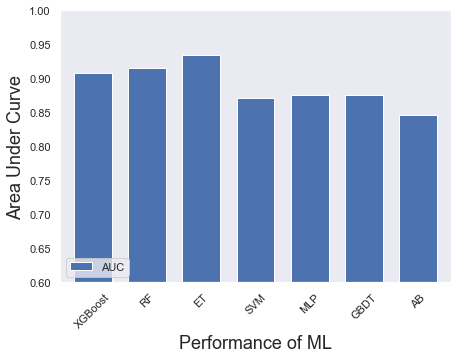

In [25]:
evals = ALL_eval.loc[['AUC'],:]
sns.set()
evals.T.plot.bar(figsize=(7,5),rot=45,width = 0.7,grid = False)
plt.ylim(0.6,1.0)
plt.ylabel('Area Under Curve',fontsize=18)
plt.xlabel('Performance of ML',fontsize=18)
plt.legend(loc =  'lower left' )

In [26]:
ALL_eval

,XGBoost,RF,ET,SVM,MLP,GBDT,AB
ACC,0.952684,0.947426,0.950933,0.948596,0.951527,0.945674,0.942182
F1,0.534123,0.441873,0.497470,0.454301,0.570859,0.476926,0.503956
F2,0.429562,0.338019,0.389317,0.347012,0.488100,0.389025,0.443991
GMean,0.611308,0.534185,0.577902,0.541597,0.662746,0.582181,0.631348
SEN,0.380724,0.292701,0.340584,0.300277,0.445972,0.347066,0.412831
PREC,0.950000,0.977778,0.977778,1.000000,0.817589,0.796828,0.675155
SPEC,0.998121,0.999377,0.999377,1.000000,0.991222,0.993075,0.984272
MCC,0.578927,0.512856,0.556395,0.527582,0.579118,0.500356,0.496213
AUC,0.907282,0.915251,0.933768,0.870225,0.874794,0.875917,0.845543


In [52]:
index = []
ALL_eval=pd.DataFrame()
for i in ml:
    print('process_{}'.format(i))
    model = eval(i)
    Evals = cv(model,X_train_norm,y_train)
    ALL_eval = pd.concat([ALL_eval,Evals],axis=1)
    index.append("{}".format(i))
ALL_eval.columns = index

process_XGBoost
process_RF
process_ET
process_MLP
process_GBDT
process_AB


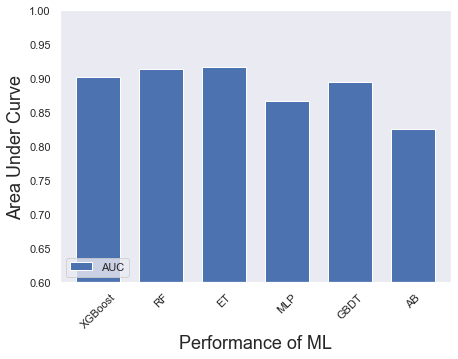

In [54]:
evals = ALL_eval.loc[['AUC'],:]
sns.set()
evals.T.plot.bar(figsize=(7,5),rot=45,width = 0.7,grid = False)
plt.ylim(0.6,1.0)
plt.ylabel('Area Under Curve',fontsize=18)
plt.xlabel('Performance of ML',fontsize=18)
plt.legend(loc =  'lower left' )

In [7]:
#下采样
from imblearn.under_sampling import NearMiss,RandomUnderSampler,ClusterCentroids
from sklearn.linear_model import LogisticRegression
#上采样与下采样结合
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE

In [8]:
nm1 = NearMiss(version=1)
nm2 = NearMiss(version=2)
nm3 = NearMiss(version=3)
rus = RandomUnderSampler(random_state=seed,replacement=True)
cc = ClusterCentroids(random_state=seed)
smotee = SMOTEENN(random_state=10)
smote = SMOTE(random_state=seed)

##### 对不平衡数据处理方法与ML进行试验

In [12]:
baml = ['nm1','nm2','nm3','rus','cc','smotee','smote']
ml_eval = pd.DataFrame()
index = []
for i in baml:
    for m in ml:
        print('process_{}'.format(m))
        X_resampled ,y_resampled = eval(i).fit_sample(X_train,y_train)
        evals = cv(eval(m),X_resampled,y_resampled)
        ml_eval = pd.concat([ml_eval,evals],axis=1)
        index.append("{}_{}".format(i,m))
ml_eval.columns = index
ml_eval.to_csv('results/balance_eval_AUC/different_balance_ml.csv')

process_XGBoost
process_RF
process_ET
process_SVM
process_GBDT
process_AB
process_XGBoost
process_RF
process_ET
process_SVM
process_GBDT
process_AB
process_XGBoost
process_RF
process_ET
process_SVM
process_GBDT
process_AB
process_XGBoost
process_RF
process_ET
process_SVM
process_GBDT
process_AB
process_XGBoost
process_RF
process_ET
process_SVM
process_GBDT
process_AB
process_XGBoost
process_RF
process_ET
process_SVM
process_GBDT
process_AB
process_XGBoost
process_RF
process_ET
process_SVM
process_GBDT
process_AB


In [14]:
baml = ['nm1','nm2','nm3','rus','cc','smotee','smote']
ml_eval_test = []
index = []
for i in baml:
    for m in ml:
        print('process_{}'.format(m))
        X_resampled ,y_resampled = eval(i).fit_sample(X_train,y_train)
        eval(m).fit(X_resampled,y_resampled)
        evals = evaluate(X_test,y_test,eval(m))
        ml_eval_test = ml_eval_test + [evals]
        index.append("{}_{}".format(i,m))
ml_eval_test = pd.DataFrame(ml_eval_test).T
ml_eval_test.columns = index
ml_eval_test.to_csv('results/balance_eval_AUC/different_balance_ml_test.csv')

process_XGBoost
process_RF
process_ET
process_SVM
process_GBDT
process_AB
process_XGBoost
process_RF
process_ET
process_SVM
process_GBDT
process_AB
process_XGBoost
process_RF
process_ET
process_SVM
process_GBDT
process_AB
process_XGBoost
process_RF
process_ET
process_SVM
process_GBDT
process_AB
process_XGBoost
process_RF
process_ET
process_SVM
process_GBDT
process_AB
process_XGBoost
process_RF
process_ET
process_SVM
process_GBDT
process_AB
process_XGBoost
process_RF
process_ET
process_SVM
process_GBDT
process_AB


In [2]:
X_train_norm = pd.read_csv('data/train/X_train_norm.csv').to_numpy()
X_test_norm = pd.read_csv('data/test/X_test_norm.csv').to_numpy()
X_train_std = pd.read_csv('data/train/X_train_std.csv').to_numpy()
X_test_std = pd.read_csv('data/test/X_test_std.csv').to_numpy()
y_train = pd.read_csv('data/train/y_train.csv').to_numpy()
y_test = pd.read_csv('data/test/y_test.csv').to_numpy()

In [9]:
baml = ['nm1','nm2','nm3','rus','cc','smotee','smote']
ml_eval = pd.DataFrame()
index = []
for i in baml:
    for m in ml:
        print('process_{}'.format(m))
        X_resampled ,y_resampled = eval(i).fit_sample(X_train_norm,y_train)
        evals = cv(eval(m),X_resampled,y_resampled)
        ml_eval = pd.concat([ml_eval,evals],axis=1)
        index.append("{}_{}".format(i,m))
ml_eval.columns = index
ml_eval.to_csv('results/balance_eval_AUC/different_balance_ml_norm.csv')

process_XGBoost
process_RF
process_ET
process_GBDT
process_XGBoost
process_RF
process_ET
process_GBDT
process_XGBoost
process_RF
process_ET
process_GBDT
process_XGBoost
process_RF
process_ET
process_GBDT
process_XGBoost
process_RF
process_ET
process_GBDT
process_XGBoost
process_RF
process_ET
process_GBDT
process_XGBoost
process_RF
process_ET
process_GBDT


In [10]:
baml = ['nm1','nm2','nm3','rus','cc','smotee','smote']
ml_eval = pd.DataFrame()
index = []
for i in baml:
    for m in ml:
        print('process_{}'.format(m))
        X_resampled ,y_resampled = eval(i).fit_sample(X_train_std,y_train)
        evals = cv(eval(m),X_resampled,y_resampled)
        ml_eval = pd.concat([ml_eval,evals],axis=1)
        index.append("{}_{}".format(i,m))
ml_eval.columns = index
ml_eval.to_csv('results/balance_eval_AUC/different_balance_ml_std.csv')

process_XGBoost
process_RF
process_ET
process_GBDT
process_XGBoost
process_RF
process_ET
process_GBDT
process_XGBoost
process_RF
process_ET
process_GBDT
process_XGBoost
process_RF
process_ET
process_GBDT
process_XGBoost
process_RF
process_ET
process_GBDT
process_XGBoost
process_RF
process_ET
process_GBDT
process_XGBoost
process_RF
process_ET
process_GBDT


In [12]:
baml = ['nm1','nm2','nm3','rus','cc','smotee','smote']
ml_eval_test = []
index = []
for i in baml:
    for m in ml:
        print('process_{}'.format(m))
        X_resampled ,y_resampled = eval(i).fit_sample(X_train_norm,y_train)
        eval(m).fit(X_resampled,y_resampled)
        evals = evaluate(X_test_norm,y_test,eval(m))
        ml_eval_test = ml_eval_test + [evals]
        index.append("{}_{}".format(i,m))
ml_eval_test = pd.DataFrame(ml_eval_test).T
ml_eval_test.columns = index
ml_eval_test.to_csv('results/balance_eval_AUC/different_balance_ml_norm_test.csv')

process_XGBoost
process_RF
process_ET
process_GBDT
process_XGBoost
process_RF
process_ET
process_GBDT
process_XGBoost
process_RF
process_ET
process_GBDT
process_XGBoost
process_RF
process_ET
process_GBDT
process_XGBoost
process_RF
process_ET
process_GBDT
process_XGBoost
process_RF
process_ET
process_GBDT
process_XGBoost
process_RF
process_ET
process_GBDT


In [13]:
baml = ['nm1','nm2','nm3','rus','cc','smotee','smote']
ml_eval_test = []
index = []
for i in baml:
    for m in ml:
        print('process_{}'.format(m))
        X_resampled ,y_resampled = eval(i).fit_sample(X_train_std,y_train)
        eval(m).fit(X_resampled,y_resampled)
        evals = evaluate(X_test_std,y_test,eval(m))
        ml_eval_test = ml_eval_test + [evals]
        index.append("{}_{}".format(i,m))
ml_eval_test = pd.DataFrame(ml_eval_test).T
ml_eval_test.columns = index
ml_eval_test.to_csv('results/balance_eval_AUC/different_balance_ml_std_test.csv')

process_XGBoost
process_RF
process_ET
process_GBDT
process_XGBoost
process_RF
process_ET
process_GBDT
process_XGBoost
process_RF
process_ET
process_GBDT
process_XGBoost
process_RF
process_ET
process_GBDT
process_XGBoost
process_RF
process_ET
process_GBDT
process_XGBoost
process_RF
process_ET
process_GBDT
process_XGBoost
process_RF
process_ET
process_GBDT


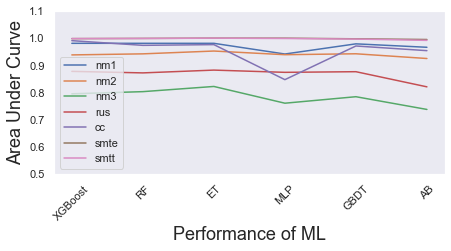

In [61]:
evals = pd.read_excel('results/balance_eval_AUC/AUC.xlsx',index_col=0)
sns.set()
evals.T.plot(figsize=(7,3),rot=45,grid = False)
plt.ylim(0.5,1.1)
plt.ylabel('Area Under Curve',fontsize=18)
plt.xlabel('Performance of ML',fontsize=18)
plt.legend(loc =  'lower left' )